<a href="https://colab.research.google.com/github/ManishK96/IPL_score_Predictor/blob/main/IPL_Score_Prediction_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing all necessary packages

In [37]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib
from google.colab import files
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
import matplotlib.pyplot as plt
from numpy import argmax
from keras.utils import to_categorical
import random



Loading dataset allmatches.csv

In [38]:
github_url = "https://raw.githubusercontent.com/ManishK96/IPL_score_Predictor/main/training_data_jaitley_stadium_csk_vs_srh.csv"
df=pd.read_csv(github_url)

Pre Processing DataSet
Step 1 : Remove columns with NaN, and other unnecessary columns

In [7]:
df2= df.dropna(axis=0,how='all')
#df2= df1.dropna(axis=1)
df2.head()

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,bowler,runs_off_bat,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed
0,729283,2014,18-04-14,Sheikh Zayed Stadium,1,0.1,Chennai Super Kings,Punjab Kings,DR Smith,BB McCullum,AR Patel,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,729283,2014,18-04-14,Sheikh Zayed Stadium,1,0.2,Chennai Super Kings,Punjab Kings,BB McCullum,DR Smith,AR Patel,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,729283,2014,18-04-14,Sheikh Zayed Stadium,1,0.3,Chennai Super Kings,Punjab Kings,BB McCullum,DR Smith,AR Patel,0,5,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,729283,2014,18-04-14,Sheikh Zayed Stadium,1,0.4,Chennai Super Kings,Punjab Kings,BB McCullum,DR Smith,AR Patel,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,729283,2014,18-04-14,Sheikh Zayed Stadium,1,0.5,Chennai Super Kings,Punjab Kings,BB McCullum,DR Smith,AR Patel,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df2 = df2.drop(columns=["wides", "noballs", "byes", "legbyes", "penalty", "player_dismissed", "other_player_dismissed"])

df2["total_runs"] = df2["runs_off_bat"]+df2["extras"]

df2 = df2.replace(to_replace=["caught", "bowled", "run out", "lbw", "stumped", "caught and bowled", "hit wicket", "retired hurt", "obstructing the field"], value=1)
df2["wicket_type"] = df2["wicket_type"].fillna(0)
df2["other_wicket_type"] = df2["other_wicket_type"].fillna(0)
df2["total_wickets"] = df2["wicket_type"]+df2["other_wicket_type"]

df2 = df2.drop(columns=["runs_off_bat", "extras", "start_date", "striker", "non_striker", "bowler", "wicket_type", "other_wicket_type"])
df2.head()

,match_id,season,venue,innings,ball,batting_team,bowling_team,total_runs,total_wickets
0,729283,2014,Sheikh Zayed Stadium,1,0.1,Chennai Super Kings,Punjab Kings,1,0.0
1,729283,2014,Sheikh Zayed Stadium,1,0.2,Chennai Super Kings,Punjab Kings,2,0.0
2,729283,2014,Sheikh Zayed Stadium,1,0.3,Chennai Super Kings,Punjab Kings,5,0.0
3,729283,2014,Sheikh Zayed Stadium,1,0.4,Chennai Super Kings,Punjab Kings,0,0.0
4,729283,2014,Sheikh Zayed Stadium,1,0.5,Chennai Super Kings,Punjab Kings,0,0.0


Step 2 : Processing Rows

In [9]:
df2 = df2[df2["ball"] <= 5.6]
df2 = df2[df2["innings"] <= 2]
df_runs = df2.groupby(["match_id", "season", "venue", "innings", "batting_team", "bowling_team"]).total_runs.sum()
df2 = df2.groupby(["match_id", "season", "venue", "innings", "batting_team", "bowling_team"]).total_wickets.sum()
df2 = df2.reset_index()
df_runs = df_runs.reset_index()
df2["total_runs"] = df_runs["total_runs"]
df2 = df2.drop(columns=["match_id", "season"])
data = df2
data.head()

,venue,innings,batting_team,bowling_team,total_wickets,total_runs
0,Sheikh Zayed Stadium,1,Chennai Super Kings,Punjab Kings,0.0,70
1,Sheikh Zayed Stadium,2,Punjab Kings,Chennai Super Kings,3.0,63
2,Sheikh Zayed Stadium,1,Sunrisers Hyderabad,Rajasthan Royals,1.0,41
3,Sheikh Zayed Stadium,2,Rajasthan Royals,Sunrisers Hyderabad,2.0,30
4,Sheikh Zayed Stadium,1,Chennai Super Kings,Delhi Capitals,1.0,34


In [10]:
venue_encoder = LabelEncoder()
team_encoder = LabelEncoder()
data["venue"] = venue_encoder.fit_transform(data["venue"])
data["batting_team"] = team_encoder.fit_transform(data["batting_team"])
data["bowling_team"] = team_encoder.fit_transform(data["bowling_team"])

data.head()

,venue,innings,batting_team,bowling_team,total_wickets,total_runs
0,18,1,0,5,0.0,70
1,18,2,5,0,3.0,63
2,18,1,10,6,1.0,41
3,18,2,6,10,2.0,30
4,18,1,0,1,1.0,34


In [11]:
array = data.to_numpy()
random.shuffle(array)
X,y = array[:,:5],array[:,5]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [232]:
X_train[0:10]

array([[18.,  2.,  5.,  0.,  3.],
       [ 4.,  1.,  4.,  0.,  2.],
       [ 0.,  2.,  0.,  1.,  0.],
       [19.,  2.,  4., 10.,  2.],
       [18.,  2.,  5.,  0.,  3.],
       [16.,  1., 10.,  1.,  2.],
       [ 4.,  1.,  4.,  0.,  2.],
       [18.,  2.,  6., 10.,  2.],
       [11.,  1., 10.,  5.,  2.],
       [14.,  1.,  2., 10.,  1.]])

In [229]:
print(y_test.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test[0])

(74,)
(74, 5)
(296,)
44.0


In [12]:
name =  "Score Predictor-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir="logs/{}".format(name))

X_train_norm= preprocessing.Normalization(input_shape=[1,])
X_train_norm.adapt(X_train)

In [218]:
print(X_train_norm)

In [13]:

def plot_loss(history):
  plt.plot(history.history['loss'], label = 'loss')
  plt.plot(history.history['loss'], label = 'loss')
  plt.ylim([0,10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

In [14]:
def basic_model(norm):
  model = keras.Sequential([
                            norm,
                            tf.keras.layers.Dense(64, activation = 'relu'),
                            tf.keras.layers.Dense(64, activation = 'relu'),
                            tf.keras.layers.Dense(1)
  ])
  model.compile(optimizer='adam',
                loss='mean_absolute_error',
              metrics=['accuracy'])
  return model


In [15]:
dnn_predictor= basic_model(X_train_norm)
dnn_predictor.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,620
Trainable params: 4,609
Non-trainable params: 11
_________________________________________________________________


In [17]:
%%time
history =  dnn_predictor.fit(X_train, y_train, validation_split=0.2, verbose=0, epochs=5000,callbacks=[tensorboard])

CPU times: user 5min 54s, sys: 11 s, total: 6min 5s
Wall time: 5min 47s


In [18]:

y_test[:]

array([61., 36., 28., 44., 38., 75., 31., 55., 37., 45., 37., 56., 41.,
       59., 38., 51., 27., 66., 70., 29., 45., 35., 37., 44., 40., 42.,
       46., 38., 45., 34., 36., 46., 56., 48., 47., 52., 49., 60., 42.,
       31., 52., 70., 54., 46., 45., 46., 49., 34., 60., 55., 39., 44.,
       31., 30., 38., 63., 29., 49., 41., 34., 43., 31., 70., 70., 70.,
       27., 47., 46., 56., 31., 70., 41., 46., 39.])

In [19]:
dnn_predictor.predict(X_test)

array([[61.12948 ],
       [36.146957],
       [30.140326],
       [43.46972 ],
       [37.492264],
       [74.96453 ],
       [31.06785 ],
       [55.162228],
       [36.803547],
       [56.779358],
       [36.803547],
       [55.76113 ],
       [37.194885],
       [60.929993],
       [38.03875 ],
       [50.938118],
       [26.88841 ],
       [49.145042],
       [70.04438 ],
       [49.30126 ],
       [35.2662  ],
       [46.15055 ],
       [40.159195],
       [44.050987],
       [41.149475],
       [52.195724],
       [45.968887],
       [37.956192],
       [53.854248],
       [34.654427],
       [35.702858],
       [49.884186],
       [42.779915],
       [47.87645 ],
       [47.157772],
       [52.091423],
       [48.77758 ],
       [60.187294],
       [42.0605  ],
       [30.81678 ],
       [51.839264],
       [70.04438 ],
       [63.146313],
       [45.78    ],
       [44.999428],
       [43.654007],
       [44.940437],
       [34.291157],
       [60.187294],
       [58.265327],


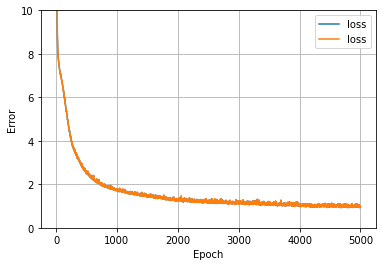

In [39]:
plot_loss(history)

In [40]:
dnn_predictor.save('C:/Users/Kiran/Downloads/27April_Submission_Manish_Rahul/dnn_model')

INFO:tensorflow:Assets written to: C:/Users/Kiran/Downloads/27April_Submission_Manish_Rahul/dnn_model/assets


In [22]:
from tensorflow import keras
model = keras.models.load_model('C:/Users/Kiran/Downloads/27April_Submission_Manish_Rahul/dnn_model')

In [25]:
model.predict(X_test)

array([[44.787262],
       [42.692165],
       [49.870605],
       [44.5388  ],
       [49.590477],
       [54.238556],
       [42.990265],
       [41.938095],
       [49.7978  ],
       [55.467377],
       [50.313377],
       [45.635426],
       [43.601807],
       [52.8183  ],
       [49.200974],
       [44.631546],
       [47.050964],
       [49.834908],
       [42.828552],
       [45.380466],
       [50.650093],
       [45.19923 ],
       [50.86338 ],
       [46.13331 ],
       [43.592014],
       [44.795433],
       [45.636345],
       [45.76876 ],
       [47.171467],
       [44.891212],
       [56.645294],
       [47.522858],
       [51.64525 ],
       [45.25143 ],
       [45.724144],
       [42.889862],
       [51.476467],
       [39.40488 ],
       [48.247643],
       [38.844337],
       [49.38852 ],
       [47.219368],
       [47.755573],
       [57.79341 ],
       [45.53292 ],
       [43.116455],
       [41.186565],
       [46.626526],
       [45.29895 ],
       [45.82819 ],


In [41]:
#joblib.(dnn_predictor,'dnn_regression_model.joblib')
joblib.dump(venue_encoder,'venue_encoder.joblib')
joblib.dump(team_encoder,'team_encoder.joblib')

['team_encoder.joblib']

In [42]:
#files.download('dnn_regression_model.joblib')
files.download('venue_encoder.joblib')
files.download('team_encoder.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib
from google.colab import files
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
import matplotlib.pyplot as plt

def predictRuns(testInput):
    prediction = 0
    ### Your Code Here ###

    #load models and encoders
    #with open("dnn_regression_model.joblib","rb") as f:
    regressor =  keras.models.load_model('C:/Users/Kiran/Downloads/27April_Submission_Manish_Rahul/dnn_model')
    with open("venue_encoder.joblib", "rb") as f:
        venue_encoder = joblib.load(f)
    with open("team_encoder.joblib","rb") as f:
        team_encoder = joblib.load(f)
    #read testcase
    test_case = pd.read_csv(testInput)

    test_case["venue"] = venue_encoder.transform(test_case["venue"])
    test_case["batting_team"] = team_encoder.transform(test_case["batting_team"])
    test_case["bowling_team"] = team_encoder.transform(test_case["bowling_team"])
    test_case["wickets"] = len(test_case["batsmen"].to_string().split(","))-1

    test_case = test_case[["venue","innings","batting_team","bowling_team","wickets"]]

    test_case = test_case.to_numpy()

    predictions = regressor.predict(test_case)

    return np.round(predictions)

In [266]:
from google.colab import files


files.upload()

{}

In [43]:
uploaded = files.upload()


Saving input3.csv to input3 (2).csv


In [36]:
### Imports ###
# add imports - classes and defs

import sys

#from predictor import predictRuns

"""
sys.argv[1] is the input test file name given as command line arguments

"""
runs = predictRuns('input3.csv')
print("Predicted Runs: ", runs)

Predicted Runs:  [[46.]]
